In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


## Fashion MNIST

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

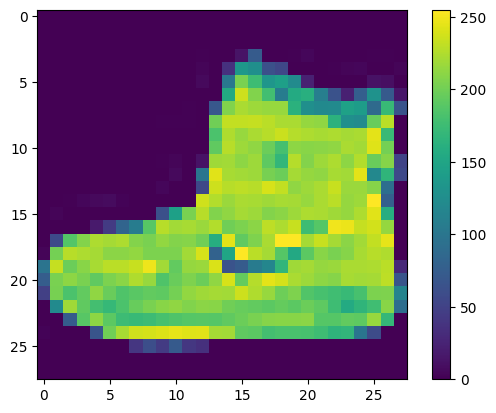

In [3]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [4]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

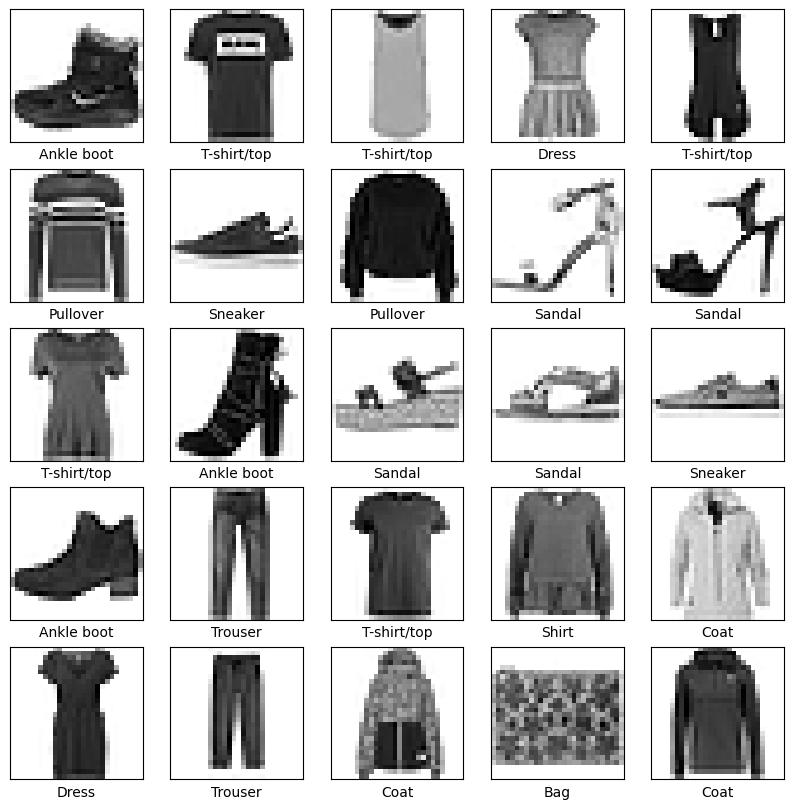

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [8]:
batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

In [9]:
# Define the input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='bidirectional_1')(x1)
x1_seq = tf.keras.layers.LSTM(64, return_sequences=True, name='LSTM_left', use_bias=False)(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='bidirectional_2')(x2)
x2_seq = tf.keras.layers.LSTM(64, return_sequences=True, name='LSTM_right', use_bias=False)(x2)

# Flatten the sequences to convert them to fixed-size vectors
x1_flattened = tf.keras.layers.Flatten()(x1_seq)
x2_flattened = tf.keras.layers.Flatten()(x2_seq)

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1_flattened, x2_flattened])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

# Create intermediate models to get outputs from bidirectional layers
intermediate_bidirectional_1_model = tf.keras.Model(inputs=input_layer, outputs=model_fashion_lstm.get_layer('bidirectional_1').output)
intermediate_bidirectional_2_model = tf.keras.Model(inputs=input_layer, outputs=model_fashion_lstm.get_layer('bidirectional_2').output)

# Summarize intermediate models
intermediate_bidirectional_1_model.summary()
intermediate_bidirectional_2_model.summary()

intermediate_LSTM_left_model = tf.keras.Model(inputs=input_layer, outputs=model_fashion_lstm.get_layer('LSTM_left').output)
intermediate_LSTM_right_model = tf.keras.Model(inputs=input_layer, outputs=model_fashion_lstm.get_layer('LSTM_right').output)

# Summarize intermediate models
intermediate_LSTM_left_model.summary()
intermediate_LSTM_right_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 permute (Permute)           (None, 28, 28)               0         ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 28, 64)               5440      ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 28, 64)               5440      ['permute[0][0]']             
                                                                                              

In [10]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=2, batch_size=batch_size)

Epoch 1/2
1875/1875 [==============================] - 65s 33ms/step - loss: 0.4697 - accuracy: 0.8274
Epoch 2/2
1875/1875 [==============================] - 59s 31ms/step - loss: 0.3364 - accuracy: 0.8760


In [11]:
# Get the intermediate outputs
bidirectional_1_output = intermediate_bidirectional_1_model.predict(fashion_test_images)
bidirectional_2_output = intermediate_bidirectional_2_model.predict(fashion_test_images)

# Display the shapes of the outputs
print("Output shape of bidirectional_1:", bidirectional_1_output.shape)
print("Output shape of bidirectional_2:", bidirectional_2_output.shape)


313/313 [==============================] - 1s 3ms/step
Output shape of bidirectional_1: (10000, 28, 128)
Output shape of bidirectional_2: (10000, 28, 128)


In [12]:
bidirectional_1_output[0,0,:]

array([-8.68938863e-03, -5.32706268e-04, -1.81798998e-03, -2.13735066e-02,
       -1.68101992e-02, -1.30001567e-02, -7.63483252e-03, -4.68074391e-03,
        1.79619493e-03,  2.19998583e-02,  3.36765172e-03,  1.64842326e-02,
       -2.01074351e-02,  5.88376913e-03, -1.32279741e-02,  4.14714171e-03,
       -1.01325093e-02, -1.86930865e-03,  8.48211162e-03, -2.01913919e-02,
       -5.61364507e-03, -1.30869290e-02, -1.28187472e-02, -1.59287136e-02,
        4.68753790e-03, -3.79301840e-03, -6.00386597e-03, -3.50699807e-03,
        1.28506217e-02, -4.30495245e-03,  1.38093736e-02, -1.42665636e-02,
       -1.18417025e-03,  1.15293032e-02,  2.31268280e-03,  1.27512468e-02,
        1.40044827e-03,  2.26062164e-03, -4.59665991e-03, -4.11005365e-03,
        6.26889581e-04, -4.81730327e-03, -1.68909458e-03,  8.99369083e-03,
       -2.13216860e-02, -1.02599207e-02, -1.11710727e-02,  1.70087256e-02,
        9.58086643e-03,  1.50146112e-02,  2.81246146e-03, -1.53961182e-02,
        8.06559052e-04,  

In [15]:
# Get the intermediate outputs
LSTM_left_output = intermediate_LSTM_left_model.predict(fashion_test_images)
LSTM_right_output = intermediate_LSTM_right_model.predict(fashion_test_images)

# Display the shapes of the outputs
print("Output shape of LSTM_left:", LSTM_left_output.shape)
print("Output shape of LSTM_right:", LSTM_right_output.shape)

313/313 [==============================] - 2s 7ms/step
Output shape of LSTM_left: (10000, 28, 64)
Output shape of LSTM_right: (10000, 28, 64)


In [13]:
LSTM_left_output[0,0,:]

array([ 0.06704475,  0.0209332 ,  0.0245077 , -0.03081647,  0.02836431,
        0.02519611, -0.01020954, -0.02323776, -0.00749918,  0.0024875 ,
        0.01608698,  0.02757655,  0.00768871, -0.02279644,  0.00945261,
       -0.01437997, -0.0175505 , -0.00377287,  0.01286319, -0.00119504,
        0.01721317, -0.04910354,  0.01593922,  0.0035017 ,  0.02042417,
       -0.02337405,  0.01293778,  0.01048243,  0.0156162 ,  0.00520799,
        0.00366759,  0.01498266, -0.00089567,  0.02002071, -0.00060987,
        0.02288068, -0.02187249,  0.00750514,  0.00584147,  0.02226749,
        0.03303505,  0.02324789, -0.03946879,  0.01202513, -0.03833425,
        0.01299756, -0.0067502 , -0.01915229, -0.01647894, -0.01534378,
        0.00606372, -0.03017202,  0.00283318, -0.01143389, -0.00655316,
       -0.00094799, -0.01583834, -0.00652271, -0.01251464, -0.01545339,
       -0.01905726,  0.00733462,  0.02155415, -0.02065737], dtype=float32)

In [16]:
input_vector = np.concatenate((bidirectional_1_output[0,0,:], LSTM_left_output[0,0,:]), axis=0)

In [13]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

313/313 [==============================] - 3s 8ms/step
0.878


In [ ]:
kernel, recurrent_kernel = model_fashion_lstm.get_layer('LSTM_right').get_weights()

In [ ]:
recurrent_kernel.shape

(64, 256)

In [ ]:
test_loss, test_acc = model_fashion_lstm.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 4s - loss: 0.3593 - accuracy: 0.8672 - 4s/epoch - 12ms/step

Test accuracy: 0.8672000169754028


In [ ]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'model/Fashion_LSTM___Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_acc}.keras'

# Save the Model.
model_fashion_lstm.save(model_file_name)

313/313 [==============================] - 3s 9ms/step
0.8815


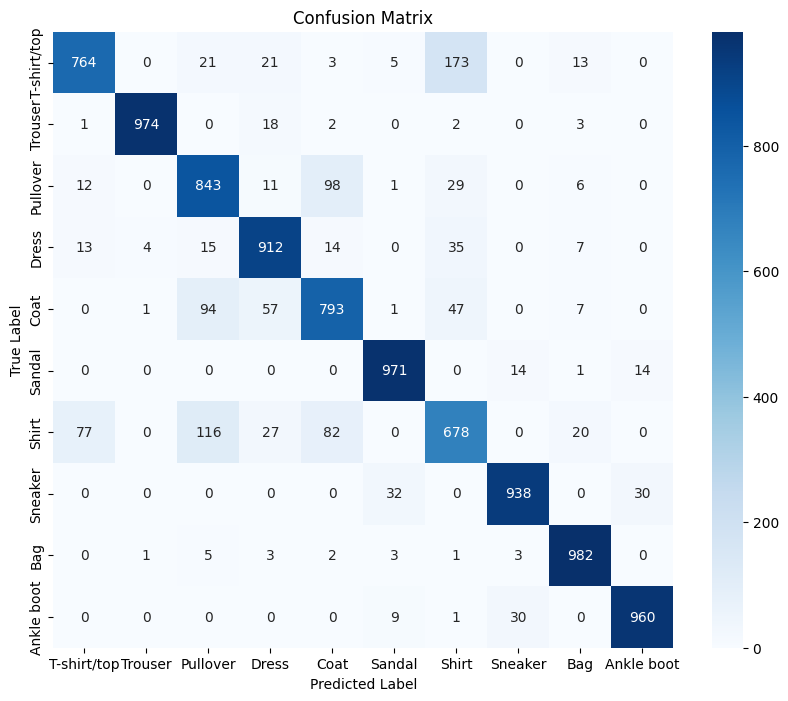

In [ ]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code/main')
from iterative_approximation.iterative_approximation import *

import statistics

In [18]:
def extract_weight_array(layer):
    kernel, recurrent_kernel = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]

In [19]:
W_array = extract_weight_array(model_fashion_lstm.get_layer('LSTM_left'))

In [ ]:
W_array[0].shape

(64, 192)

In [29]:
W = IterativeApproximation([W_array[0],W_array[1],W_array[2],W_array[3]],'array',0.001,24,72,2,2)
W1 = W.iterative_approximation_step1()
W2 = W.iterative_approximation_step1()
W3 = W.iterative_approximation_step1()
W4 = W.iterative_approximation_step1()
W5 = W.iterative_approximation_step1()
W6 = W.iterative_approximation_step1()
W7 = W.iterative_approximation_step1()


In [28]:
def combine_pairs(arr):
    # Check if the array length is even
    if len(arr) % 2 != 0:
        raise ValueError("Array length must be even")
    
    combined_arr = []
    for i in range(0, len(arr), 2):
        combined_element = (arr[i], arr[i+1])
        combined_arr.append(combined_element)
    
    return combined_arr

In [121]:
def float_to_fixed(val, int_bits=3, frac_bits=28):
    scale = 2 ** frac_bits
    max_val = 2 ** (int_bits + frac_bits) - 1
    min_val = -2 ** (int_bits + frac_bits)
    
    fixed_val = np.round(val * scale).astype(np.int32)
    fixed_val = np.clip(fixed_val, min_val, max_val)
    return fixed_val

def w_storage_to_coe1(storage, int_bits=3, frac_bits=28):
    u_pruned = [[] for _ in range(len(storage))]
    for i in range(len(storage)):
        for j in range(len(storage[0])):
            u_pruned_j = [x for x in storage[i][j][0] if x != 0]
            u_pruned[i].extend(u_pruned_j)

    with open('u_pruned.coe', 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')

        for i in range(0, len(u_pruned[0]), 2):
            hex_vals = []
            for j in range(len(storage)):
                val1 = u_pruned[j][i]
                val2 = u_pruned[j][i + 1]
                fixed_val1 = float_to_fixed(val1, int_bits, frac_bits)
                fixed_val2 = float_to_fixed(val2, int_bits, frac_bits)
                hex_val1 = hex(fixed_val1 & 0xFFFFFFFF)[2:].upper()
                hex_vals.append(f'{hex_val1:0>8}')
                hex_val2 = hex(fixed_val2 & 0xFFFFFFFF)[2:].upper()
                hex_vals.append(f'{hex_val2:0>8}')

            f.write(''.join(hex_vals))
            if i < len(u_pruned[0]) - 2:
                f.write(',\n')
            else:
                f.write(';\n')

    v_pruned = [[] for _ in range(len(storage))]
    for i in range(len(storage)):
        for j in range(len(storage[0])):
            v_pruned_j = [x for x in storage[i][j][2] if x != 0]
            v_pruned[i].extend(v_pruned_j)

    with open('v_pruned.coe', 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')

        for i in range(0, len(v_pruned[0]), 2):
            hex_vals = []
            for j in range(len(storage)):
                val1 = v_pruned[j][i]
                val2 = v_pruned[j][i + 1]
                fixed_val1 = float_to_fixed(val1, int_bits, frac_bits)
                fixed_val2 = float_to_fixed(val2, int_bits, frac_bits)
                hex_val1 = hex(fixed_val1 & 0xFFFFFFFF)[2:].upper()
                hex_vals.append(f'{hex_val1:0>8}')
                hex_val2 = hex(fixed_val2 & 0xFFFFFFFF)[2:].upper()
                hex_vals.append(f'{hex_val2:0>8}')

            f.write(''.join(hex_vals))
            if i < len(v_pruned[0]) - 2:
                f.write(',\n')
            else:
                f.write(';\n')

def w_storage_to_coe2(storage, int_bits=3, frac_bits=28):
    s_pruned = [[] for _ in range(len(storage))]
    for i in range(len(storage)):
        for j in range(len(storage[0])):
            s_pruned_j = [storage[i][j][1]]
            s_pruned[i].extend(s_pruned_j)
            
    with open('s_pruned.coe', 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')
        
        for i in range(len(s_pruned[0])):
            hex_vals = []
            for j in range(len(storage)):
                val = s_pruned[j][i]
                fixed_val = float_to_fixed(val, int_bits, frac_bits)
                hex_val2 = hex(fixed_val & 0xFFFFFFFF)[2:].upper()
                hex_vals.append(f'{hex_val2:0>8}')
    
            f.write(''.join(hex_vals))
            if i < len(s_pruned[0]) - 1:
                f.write(',\n')
            else:
                f.write(';\n')

def bin_array_to_coe(arr, filename):
    # Write the hexadecimal number into the COE file
    with open(filename, 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')
        for i, val in enumerate(arr):
            # Convert the array of 1s and 0s into a single binary string
            bin_str = ''.join(str(bit) for bit in val)
            
            # Convert the binary string into a hexadecimal number
            hex_str = hex(int(bin_str, 2))[2:].upper()
            f.write(hex_str)
            if i < len(arr) - 1:
                f.write(',\n')
            else:
                f.write(';\n')

def w_storage_to_coe3(mask_storage, int_bits=3, frac_bits=28):
    mask_v = [[] for _ in range(len(mask_storage))]
    for i in range(len(mask_storage)):
        for j in range(len(mask_storage[0])):
            # Assuming mask_storage[i][j][1] directly contains the bit (not a list of bits)
            mask_v[i].append(mask_storage[i][j][1])  # Simplified to just store the value

    with open('mask_v.coe', 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')
        for j in range(len(mask_storage[0])):
            hex_vals = []
            for i in range(len(mask_storage)):
                # Convert the list of bits into a single binary string
                bin_str = ''.join(str(bit) for bit in mask_v[i][j])
                hex_str = hex(int(bin_str, 2))[2:].upper()
                hex_vals.append(hex_str)

            # Joining hex values for writing into the file
            f.write(''.join(hex_vals))
            if j < len(mask_storage[0]) - 1:
                f.write(',\n')
            else:
                f.write(';\n')

    mask_u = [[] for _ in range(len(mask_storage))]
    for i in range(len(mask_storage)):
        for j in range(len(mask_storage[0])):
            # Assuming mask_storage[i][j][1] directly contains the bit (not a list of bits)
            mask_u[i].append(mask_storage[i][j][0])  # Simplified to just store the value

    with open('mask_u.coe', 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')
        for j in range(len(mask_storage[0])):
            hex_vals = []
            for i in range(len(mask_storage)):
                # Convert the list of bits into a single binary string
                bin_str = ''.join(str(bit) for bit in mask_u[i][j])
                hex_str = hex(int(bin_str, 2))[2:].upper()
                hex_vals.append(hex_str)

            # Joining hex values for writing into the file
            f.write(''.join(hex_vals))
            if j < len(mask_storage[0]) - 1:
                f.write(',\n')
            else:
                f.write(';\n')


In [58]:
w_storage_to_coe1(W.U_S_Vt_storage, int_bits=3, frac_bits=28)

In [135]:
w_storage_to_coe2(W.U_S_Vt_storage, int_bits=3, frac_bits=28)


In [122]:
w_storage_to_coe3(W.mask_storage, int_bits=3, frac_bits=28)


In [117]:
mask_v_1 = W.mask_storage[3][0][1]
len(mask_v_1)

96

In [118]:
mask_v_2 = W.mask_storage[3][1][1]

In [119]:
mask_v_3 = W.mask_storage[3][2][1]

In [120]:
mask_v_0 = [mask_v_1] + [mask_v_2] + [mask_v_3]
bin_array_to_coe(mask_v_0, 'mask_v_0.coe')

In [71]:
s_pruned_1 = W.U_S_Vt_storage[2][0][1]
s_pruned_2 = W.U_S_Vt_storage[2][1][1]
s_pruned_3 = W.U_S_Vt_storage[2][2][1]
s_pruned_4 = W.U_S_Vt_storage[2][3][1]
s_pruned_5 = W.U_S_Vt_storage[2][4][1]
s_pruned_6 = W.U_S_Vt_storage[2][5][1]
s_pruned_7 = W.U_S_Vt_storage[2][6][1]

s_pruned_0 = [s_pruned_1] + [s_pruned_2] + [s_pruned_3] + [s_pruned_4] + [s_pruned_5] + [s_pruned_6] + [s_pruned_7]
array_to_coe(s_pruned_0,'s_pruned_tile_size_2.coe',1)

In [309]:
s_pruned_3 = W.U_S_Vt_storage[2][1]
s_pruned_3

2.4806364787151947

In [310]:
s_pruned = [s_pruned_1] + [s_pruned_2] + [s_pruned_3]
s_pruned

[3.7016206, 3.290494095618542, 2.4806364787151947]

In [311]:
u_pruned_1 = [x for x in W.U_S_Vt_storage[0][0] if x != 0]
len(u_pruned_1)

48

In [312]:
u_pruned_2 = [x for x in W.U_S_Vt_storage[1][0] if x != 0]

In [313]:
u_pruned_3 = [x for x in W.U_S_Vt_storage[2][0] if x != 0]

In [314]:
u_pruned = u_pruned_1 + u_pruned_2 + u_pruned_3
len(u_pruned)

144

In [128]:
mask_u_1 = W.mask_storage[3][0][0]
len(mask_u_1)

32

In [129]:
mask_u_2 = W.mask_storage[3][1][0]

In [130]:
mask_u_3 = W.mask_storage[3][2][0]

In [131]:
mask_u_0 = [mask_u_1] + [mask_u_2] + [mask_u_3]
bin_array_to_coe(mask_u_0, 'mask_u_0.coe')

In [132]:
input_vector

array([-8.68938863e-03, -5.32706268e-04, -1.81798998e-03, -2.13735066e-02,
       -1.68101992e-02, -1.30001567e-02, -7.63483252e-03, -4.68074391e-03,
        1.79619493e-03,  2.19998583e-02,  3.36765172e-03,  1.64842326e-02,
       -2.01074351e-02,  5.88376913e-03, -1.32279741e-02,  4.14714171e-03,
       -1.01325093e-02, -1.86930865e-03,  8.48211162e-03, -2.01913919e-02,
       -5.61364507e-03, -1.30869290e-02, -1.28187472e-02, -1.59287136e-02,
        4.68753790e-03, -3.79301840e-03, -6.00386597e-03, -3.50699807e-03,
        1.28506217e-02, -4.30495245e-03,  1.38093736e-02, -1.42665636e-02,
       -1.18417025e-03,  1.15293032e-02,  2.31268280e-03,  1.27512468e-02,
        1.40044827e-03,  2.26062164e-03, -4.59665991e-03, -4.11005365e-03,
        6.26889581e-04, -4.81730327e-03, -1.68909458e-03,  8.99369083e-03,
       -2.13216860e-02, -1.02599207e-02, -1.11710727e-02,  1.70087256e-02,
        9.58086643e-03,  1.50146112e-02,  2.81246146e-03, -1.53961182e-02,
        8.06559052e-04,  

In [136]:
def float_to_fixed(val, int_bits=3, frac_bits=28):
    scale = 2 ** frac_bits
    max_val = 2 ** (int_bits + frac_bits) - 1
    min_val = -2 ** (int_bits + frac_bits)
    
    fixed_val = np.round(val * scale).astype(np.int32)
    fixed_val = np.clip(fixed_val, min_val, max_val)
    return fixed_val

def array_to_coe(arr, filename, tile_size, int_bits=3, frac_bits=28):
    with open(filename, 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')

        hex_vals = []  # Initialize hex_vals list

        if isinstance(arr, (float, np.float32, np.float64)):
            fixed_val = float_to_fixed(arr, int_bits, frac_bits)
            hex_val = hex(fixed_val & 0xFFFFFFFF)[2:].upper()
            f.write(f'{hex_val:0>4}')
            f.write(';\n')
        else:
            for i, val in enumerate(arr):
                fixed_val = float_to_fixed(val, int_bits, frac_bits)
                hex_val = hex(fixed_val & 0xFFFFFFFF)[2:].upper()
                hex_vals.append(f'{hex_val:0>8}')
                
                # Concatenate every 'tile_size' hex values
                if (i + 1) % tile_size == 0 or i == len(arr) - 1:
                    concatenated_hex = ''.join(hex_vals)
                    f.write(concatenated_hex)
                    if i < len(arr) - 1:
                        f.write(',\n')
                    else:
                        f.write(';\n')
                    hex_vals = []  # Reset for the next group of tile_size


In [137]:
def bin_array_to_coe(arr, filename):
    # Write the hexadecimal number into the COE file
    with open(filename, 'w') as f:
        f.write('memory_initialization_radix=16;\n')
        f.write('memory_initialization_vector=\n')
        for i, val in enumerate(arr):
            # Convert the array of 1s and 0s into a single binary string
            bin_str = ''.join(str(bit) for bit in val)
            
            # Convert the binary string into a hexadecimal number
            hex_str = hex(int(bin_str, 2))[2:].upper()
            f.write(hex_str)
            if i < len(arr) - 1:
                f.write(',\n')
            else:
                f.write(';\n')

In [185]:
dot_product1 = W.U_S_Vt_storage[0][0][2] @ input_vector * W.U_S_Vt_storage[0][0][1] * W.U_S_Vt_storage[0][0][0] #+ W.U_S_Vt_storage[0][1][2] @ input_vector * W.U_S_Vt_storage[0][1][1] * W.U_S_Vt_storage[0][1][0] + W.U_S_Vt_storage[0][2][2] @ input_vector * W.U_S_Vt_storage[0][2][1] * W.U_S_Vt_storage[0][2][0] + W.U_S_Vt_storage[0][3][2] @ input_vector * W.U_S_Vt_storage[0][3][1] * W.U_S_Vt_storage[0][3][0] + W.U_S_Vt_storage[0][4][2] @ input_vector * W.U_S_Vt_storage[0][4][1] * W.U_S_Vt_storage[0][4][0]  + W.U_S_Vt_storage[0][5][2] @ input_vector * W.U_S_Vt_storage[0][5][1] * W.U_S_Vt_storage[0][5][0] 
array_to_coe(dot_product1,'dot_product1.coe',1)

In [180]:
dot_product1 = W.U_S_Vt_storage[0][0][2] @ input_vector * W.U_S_Vt_storage[0][0][1] * W.U_S_Vt_storage[0][0][0] + W.U_S_Vt_storage[0][1][2] @ input_vector * W.U_S_Vt_storage[0][1][1] * W.U_S_Vt_storage[0][1][0] + W.U_S_Vt_storage[0][2][2] @ input_vector * W.U_S_Vt_storage[0][2][1] * W.U_S_Vt_storage[0][2][0] + W.U_S_Vt_storage[0][3][2] @ input_vector * W.U_S_Vt_storage[0][3][1] * W.U_S_Vt_storage[0][3][0] + W.U_S_Vt_storage[0][4][2] @ input_vector * W.U_S_Vt_storage[0][4][1] * W.U_S_Vt_storage[0][4][0]  + W.U_S_Vt_storage[0][5][2] @ input_vector * W.U_S_Vt_storage[0][5][1] * W.U_S_Vt_storage[0][5][0] + W.U_S_Vt_storage[0][6][2] @ input_vector * W.U_S_Vt_storage[0][6][1] * W.U_S_Vt_storage[0][6][0] 
array_to_coe(dot_product1,'dot_product1.coe',1)

In [139]:
result0 = W7[0] @ input_vector
result1 = W7[1] @ input_vector
result2 = W7[2] @ input_vector
result3 = W7[3] @ input_vector

In [144]:
array_to_coe(result0,'result0.coe',1)

In [145]:
array_to_coe(result1,'result1.coe',1)

In [146]:
array_to_coe(result2,'result2.coe',1)

In [147]:
array_to_coe(result3,'result3.coe',1)